<a href="https://colab.research.google.com/github/ravichas/AMPL-workshop-1/blob/main/EDA_With_Harmonization_Using_AMPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> **Exploratory Data Analysis with Harmonization using AMPL** </center>


***Please note that this is not a solutions notebook. We provide some of Exploratory Data Analysis (EDA) ideas that are relevant for drug discovery. If you think additional steps should be included, please let us know.***

In this notebook we will analyze molecular data and assay measurements for datasets collected from ChEMBL and Excape-DB.
1. ***COPY*** this notebook into your own google drive. Work and edit from that one
2. For this tutorial, we will use HTR3A target (https://www.ncbi.nlm.nih.gov/gene/3359) binding data from three different data sources, Excape-DB and ChEMBL. *If you want to use your own target, you can download your target related data from the following databases*:
  - https://www.ebi.ac.uk/chembl/
  - https://solr.ideaconsult.net/search/excape/


# **Scope of the tutorial:**



*   Load the datasets
  * For demonstration, we have chosen only two sources (ChEMBL and ExCAPE-DB), one could add more datasources (Drug Target Commons, DTC). 
*   Clean and examine the data
*   Merge the datasets
*   Examine compound diversity
*   Create curated data 
*   Store the ML ready data (in Google Drive) for modeling

**Plesae note that this notebook provides some ideas on how to collect, merge and curate datasets. There are many other ways of accomplishing the same and it depends on the dataset(s) sources. AMPL will help you accomplish these steps reliably and with less coding.**

# **Google COLAB Environment** 



* Serverless environment for Jupyter notebook
* It is a VM on the cloud running Ubuntu 
* Free CPU/GPU (**Resources are unlimited with no-gurantee**)

https://github.com/ravichas/AMPL-Tutorial/blob/master/00_BasicCOLAB_Tutorial.ipynb


# **AMPL Tutorials** 



More elaborate tutorial on this and other topics are available from the following AMPL link,  
https://github.com/ATOMconsortium/AMPL/tree/Tutorials/atomsci/ddm/examples/tutorials

#**How to install/use AMPL?**

In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

!pip install deepchem-nightly

import deepchem
deepchem.__version__

! pip install umap
! pip install llvmlite==0.34.0  --ignore-installed
! pip install umap-learn
! pip install molvs
! pip install bravado

In [ ]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

# **Load AMPL/relevant Libraries**

In [3]:
# Temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import pandas as pd
import json
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_venn as mpv
from scipy.stats import pearsonr

# set up sns visualization parameters
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

In [4]:
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd

# Additional python libraries
import pandas as pd
import numpy as np
import getpass, os

# **HTR3A Protein Target For Demo**




*   Hydroxytrptamine receptor 3A (HTR3A)
*   HTR3A gene also encodes a protein also called HTR3A 
*   HTR3A belongs to ligand-gated ion channel receptor subfamily. It is a receptor for 5-hydroxytryptamine (serotonin) 
  * Serotonin: a harmone, functions as a neurtransmitter 
*   Receptor as homopentamer or combining with other subtypes to form the biologicaly active heteropentameric form to become biologically active


In [5]:
pip install py3Dmol

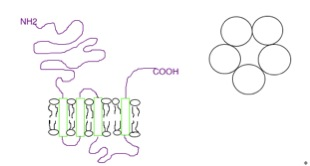

In [6]:
from IPython.display import Image
Image("https://upload.wikimedia.org/wikipedia/commons/8/84/Ionophore_receptor.jpg",
      width=500)

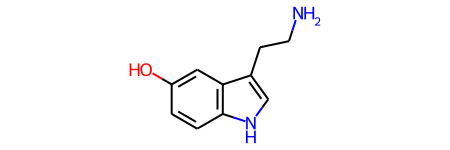

In [7]:
# Serotonin
from IPython.core.display import Image
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

mol = Chem.MolFromSmiles("C1=CC2=C(C=C1O)C(=CN2)CCN")
Chem.rdDepictor.SetPreferCoordGen(True)
Chem.rdDepictor.Compute2DCoords(mol)

mol

In [8]:
import py3Dmol 
view=py3Dmol.view(query='pdb:6y5a')
view.setStyle({'cartoon':{'color':'spectrum'}})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# **Why HTR3A?**

* Therapeutic target for cancer therapies  
* HTR3A approved FDA drug target
* Variants associated with psychiatric disorders such as biploar disorders/depression

# **Data Sources?** 

ChEMBL contains all the PubChem data. Excape and DTC (Drug Target Commons) contains curated data and also include mutation data. For this demonstration, we have used only ChEMBL and Excape-DB.



# **Data Ingestion**

In [9]:
! wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/A-HTR3A/HTR3A_Excape.csv
! wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/A-HTR3A/HTR3A_ChEMBL.csv

--2021-05-31 13:55:20--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/A-HTR3A/HTR3A_Excape.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93353 (91K) [text/plain]
Saving to: ‘HTR3A_Excape.csv’

HTR3A_Excape.csv    100%[===================>]  91.17K  --.-KB/s    in 0.03s   

2021-05-31 13:55:21 (2.66 MB/s) - ‘HTR3A_Excape.csv’ saved [93353/93353]

--2021-05-31 13:55:21--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/A-HTR3A/HTR3A_ChEMBL.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response..

In [10]:
excape = pd.read_csv("HTR3A_Excape.csv", sep=',', header=0)
chembl = pd.read_csv("HTR3A_ChEMBL.csv", sep=',', header=0 )

In [11]:
# excape.iloc[1:3,]

In [12]:
# chembl.iloc[1:3, ]

# **Explore the loaded ChEMBL and Excape dataframes**
 
Here is a list of possible questions during exploration:

- Number of data points in each file?
- Molecular identifiers from each file?
- Data types from each file?
- Data units in each file?
- What is the formula to translate IC50 to pIC50?
- What other information might be useful?
- What molecular (and other) identifiers exist for compounds from each database?
- What assay response types are there in each file?
- Think how we might combine these data sources together

In [13]:
print(chembl.shape)
print(excape.shape)

(1950, 45)
(649, 11)


## **Examine and clean data** 

### Questions to ask while exploring data


In [14]:
# first let us get rid of spaces
chembl.columns = chembl.columns.str.replace(' ','_') 
excape.columns = excape.columns.str.replace(' ','_') 

# **Explore ChEMBL `dataset**

ChEMBL bioassay publication: https://academic.oup.com/nar/article/47/D1/D930/5162468

**Number of data points?**

In [15]:
chembl.shape

(1950, 45)

In [16]:
chembl.head()

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase Molecular_Weight  \
0      CHEMBL3233676           NaN                   0           622.85   
1          CHEMBL773       GLYCINE                   4            75.07   
2      CHEMBL3261486           NaN                   0           312.37   
3      CHEMBL3943065           NaN                   0           401.47   
4      CHEMBL2086584           NaN                   0           427.55   

  #RO5_Violations  AlogP Compound_Key  \
0               2   6.84          22a   
1               0  -0.97      glycine   
2               0   0.88            9   
3               0   2.21   BDBM221658   
4               0   2.99           27   

                                              Smiles Standard_Type  \
0  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...    Inhibition   
1                                           NCC(=O)O          EC50   
2    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2      Activity   
3   CN1C2COCC1CC(NC(=O)c1cn(-c3cscn3)c3ncc(F)cc13)C2          IC50   
4  COc1ccc(-c2cc(NC(=O)C(C)CCCN3CCCN(C(C)=O)CC3)[...          IC50   

  Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
0               '='           13.75              %            NaN   
1               NaN             NaN            NaN            NaN   
2               '='           83.00              %            NaN   
3               '='            1.81             nM           8.74   
4               '>'        30000.00             nM            NaN   

  Data_Validity_Comment         Comment    Uo_Units  Ligand_Efficiency_BEI  \
0                   NaN             NaN  UO_0000187                    NaN   
1                   NaN  Not Determined         NaN                    NaN   
2                   NaN             NaN  UO_0000187                    NaN   
3                   NaN          388070  UO_0000065                  21.78   
4                   NaN             NaN  UO_0000065                    NaN   

  Ligand_Efficiency_LE Ligand_Efficiency_LLE Ligand_Efficiency_SEI  \
0                  NaN                   NaN                   NaN   
1                  NaN                   NaN                   NaN   
2                  NaN                   NaN                   NaN   
3                 0.43                  6.53                  12.1   
4                  NaN                   NaN                   NaN   

   Potential_Duplicate Assay_ChEMBL_ID  \
0                False   CHEMBL3240658   
1                False    CHEMBL896288   
2                False   CHEMBL3268498   
3                False   CHEMBL3888296   
4                False   CHEMBL2091623   

                                   Assay_Description Assay_Type BAO_Format_ID  \
0  Reversible inhibition of human 5-HT3A expresse...          B   BAO_0000219   
1  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   
2  Partial agonist activity at human 5-HT3A recep...          B   BAO_0000219   
3  In Vitro Inhibition of Ca Flux Assay: The 5HT3...          B   BAO_0000219   
4  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   

           BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID Assay_Tissue_Name  \
0  cell-based format   Homo sapiens                   None              None   
1  cell-based format   Homo sapiens                   None              None   
2  cell-based format   Homo sapiens                   None              None   
3  cell-based format   Homo sapiens                   None              None   
4  cell-based format   Homo sapiens                   None              None   

  Assay_Cell_Type Assay_Subcellular_Fraction Assay_Parameters  \
0            None                       None              NaN   
1          HEK293                       None              NaN   
2          HEK293                       None              NaN   
3        HEK-293T                       None              NaN   
4          HEK293               

**Chembl Standard Units:**

According to Chembl, *The published units are taken directly from the literature and we then attempt to standardise these to report as a **standard type**. This is an ongoing curation task, which was started with the most common units first.*

In [17]:
chembl.Standard_Type.value_counts()

Ki                                                     611
IC50                                                   558
Inhibition                                             478
Activity                                               138
Ka                                                      46
EC50                                                    41
Vmax                                                    25
Kd                                                      22
% Inhibition of Control Specific Binding (Mean n=2)      8
% Ctrl                                                   8
pKi                                                      4
Efficacy                                                 4
pIC50                                                    3
Emax                                                     2
Kb                                                       1
Selectivity ratio                                        1
Name: Standard_Type, dtype: int64

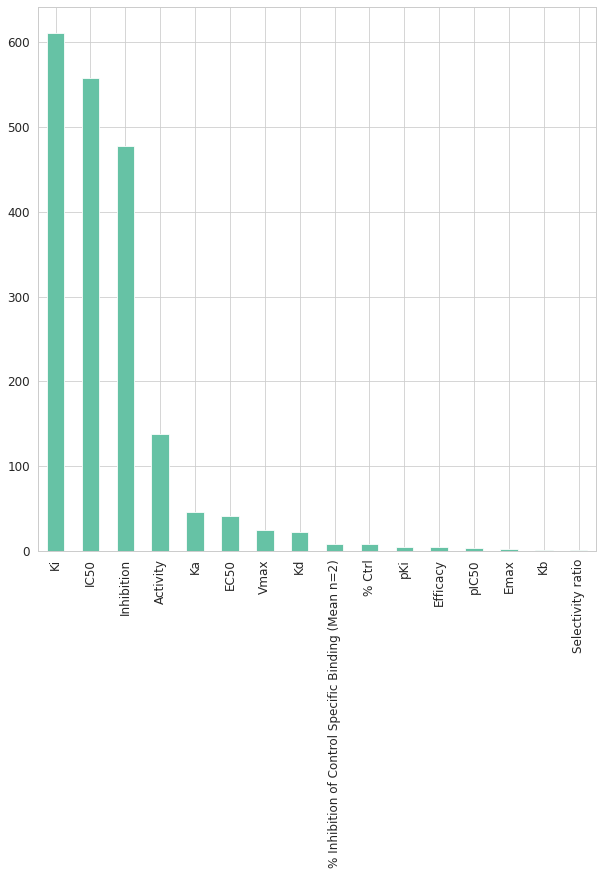

In [18]:
chembl.Standard_Type.value_counts().plot(kind='bar')

In [19]:
chembl.Assay_Description

0       Reversible inhibition of human 5-HT3A expresse...
1       Antagonist activity at human 5HT3A receptor ex...
2       Partial agonist activity at human 5-HT3A recep...
3       In Vitro Inhibition of Ca Flux Assay: The 5HT3...
4       Antagonist activity at human 5HT3A receptor ex...
                              ...                        
1945                  GPCRScan assay: inhibition of 5-HT3
1946                  GPCRScan assay: inhibition of 5-HT3
1947                  GPCRScan assay: inhibition of 5-HT3
1948    Antagonist activity at human 5-HT3A receptor e...
1949    Displacement of [3H]-GR65630 from human 5-HT3 ...
Name: Assay_Description, Length: 1950, dtype: object

In [20]:
chembl.head(3)

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase Molecular_Weight  \
0      CHEMBL3233676           NaN                   0           622.85   
1          CHEMBL773       GLYCINE                   4            75.07   
2      CHEMBL3261486           NaN                   0           312.37   

  #RO5_Violations  AlogP Compound_Key  \
0               2   6.84          22a   
1               0  -0.97      glycine   
2               0   0.88            9   

                                              Smiles Standard_Type  \
0  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...    Inhibition   
1                                           NCC(=O)O          EC50   
2    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2      Activity   

  Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
0               '='           13.75              %            NaN   
1               NaN             NaN            NaN            NaN   
2               '='           83.00              %            NaN   

  Data_Validity_Comment         Comment    Uo_Units  Ligand_Efficiency_BEI  \
0                   NaN             NaN  UO_0000187                    NaN   
1                   NaN  Not Determined         NaN                    NaN   
2                   NaN             NaN  UO_0000187                    NaN   

  Ligand_Efficiency_LE Ligand_Efficiency_LLE Ligand_Efficiency_SEI  \
0                  NaN                   NaN                   NaN   
1                  NaN                   NaN                   NaN   
2                  NaN                   NaN                   NaN   

   Potential_Duplicate Assay_ChEMBL_ID  \
0                False   CHEMBL3240658   
1                False    CHEMBL896288   
2                False   CHEMBL3268498   

                                   Assay_Description Assay_Type BAO_Format_ID  \
0  Reversible inhibition of human 5-HT3A expresse...          B   BAO_0000219   
1  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   
2  Partial agonist activity at human 5-HT3A recep...          B   BAO_0000219   

           BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID Assay_Tissue_Name  \
0  cell-based format   Homo sapiens                   None              None   
1  cell-based format   Homo sapiens                   None              None   
2  cell-based format   Homo sapiens                   None              None   

  Assay_Cell_Type Assay_Subcellular_Fraction Assay_Parameters  \
0            None                       None              NaN   
1          HEK293                       None              NaN   
2          HEK293                       None              NaN   

  Assay_Variant_Accession Assay_Variant_Mutation Target_ChEMBL_ID  \
0                     NaN                    NaN       CHEMBL1899   
1                     NaN                    NaN       CHEMBL1899   
2                     NaN                    NaN       CHEMBL1899   

                      Target_Name Target_Organism     Target_Type  \
0  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   
1  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   
2  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   

  Document_ChEMBL_ID  Source_ID     Source_Description  \
0      CHEMBL3232706          1  Scientific Literature   
1      CHEMBL1148788          1  Scientific Literature   
2      CHEMBL3259590          1  Scientific Literature   

           Document_Journal  Document_Year Cell_ChEMBL_ID Properties  
0        Eur. J. Med. Chem.         2014.0           None        NaN  
1             J. Med. Chem.         2007.0  CHEMBL3307715        NaN  
2  Bioorg. Med. Chem. Lett.         2014.0  CHEMBL3307715        NaN

In [21]:
chembl.Standard_Units.unique()

array(['%', nan, 'nM', 'uM'], dtype=object)

In [22]:
chembl[chembl.Standard_Type == "IC50"].head(5)

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase Molecular_Weight  \
3      CHEMBL3943065           NaN                   0           401.47   
4      CHEMBL2086584           NaN                   0           427.55   
5      CHEMBL3982898           NaN                   0           349.38   
6      CHEMBL1180293    ALCURONIUM                   0           666.91   
7       CHEMBL206666           NaN                   0           614.47   

  #RO5_Violations AlogP Compound_Key  \
3               0  2.21   BDBM221658   
4               0  2.99           27   
5               0  2.16   BDBM221679   
6               2  5.48           23   
7               1  5.53           20   

                                              Smiles Standard_Type  \
3   CN1C2COCC1CC(NC(=O)c1cn(-c3cscn3)c3ncc(F)cc13)C2          IC50   
4  COc1ccc(-c2cc(NC(=O)C(C)CCCN3CCCN(C(C)=O)CC3)[...          IC50   
5         O=C(NC1CC2COCC(C1)N2)c1cn(CC(F)F)c2ccccc12          IC50   
6  C=CC[N+]12CC[C@@]34c5ccccc5N5/C=C6/[C@H]7C[C@H...          IC50   
7  C=CC[N+](C)(C)Cc1c2n(c3ccccc13)Cc1c(C[N+](C)(C...          IC50   

  Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
3               '='            1.81             nM           8.74   
4               '>'        30000.00             nM            NaN   
5               '='            0.40             nM           9.40   
6               '>'       100000.00             nM            NaN   
7               '>'       100000.00             nM            NaN   

  Data_Validity_Comment Comment    Uo_Units  Ligand_Efficiency_BEI  \
3                   NaN  388070  UO_0000065                  21.78   
4                   NaN     NaN  UO_0000065                    NaN   
5                   NaN  388138  UO_0000065                  26.90   
6                   NaN     NaN  UO_0000065                    NaN   
7                   NaN     NaN  UO_0000065                    NaN   

  Ligand_Efficiency_LE Ligand_Efficiency_LLE Ligand_Efficiency_SEI  \
3                 0.43                  6.53                  12.1   
4                  NaN                   NaN                   NaN   
5                 0.51                  7.24                    17   
6                  NaN                   NaN                   NaN   
7                  NaN                   NaN                   NaN   

   Potential_Duplicate Assay_ChEMBL_ID  \
3                False   CHEMBL3888296   
4                False   CHEMBL2091623   
5                False   CHEMBL3888296   
6                False    CHEMBL896288   
7                False    CHEMBL896288   

                                   Assay_Description Assay_Type BAO_Format_ID  \
3  In Vitro Inhibition of Ca Flux Assay: The 5HT3...          B   BAO_0000219   
4  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   
5  In Vitro Inhibition of Ca Flux Assay: The 5HT3...          B   BAO_0000219   
6  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   
7  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   

           BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID Assay_Tissue_Name  \
3  cell-based format   Homo sapiens                   None              None   
4  cell-based format   Homo sapiens                   None              None   
5  cell-based format   Homo sapiens                   None              None   
6  cell-based format   Homo sapiens                   None              None   
7  cell-based format   Homo sapiens                   None              None   

  Assay_Cell_Type Assay_Subcellular_Fraction Assay_Parameters  \
3        HEK-293T                       None              NaN   
4          HEK293                       None              NaN   
5        HEK-293T                       None              NaN   
6          HEK293                       None              NaN   
7          HEK293                       None              NaN   

  Assay_Variant_Acce

# **Explore Excape-DB dataset**

In [23]:
excape.shape

(649, 11)

In [24]:
excape.head(3)

Ambit_InchiKey Original_Entry_ID  Entrez_ID Activity_Flag  \
0  AZGOVLGMSGAOMP-FZYUQVBKNA-N      CHEMBL404232       3359             A   
1  BAZZAIKMNMNZJS-PKRZOPRNNA-N      CHEMBL494999      79246             A   
2  ARXTZNGJWWBBMH-LQFNOIFHNA-N          44157937      79246             A   

     pXC50        DB  Original_Assay_ID  Tax_ID Gene_Symbol  Ortholog_Group  \
0  5.52000  chembl20             989092    9606       HTR3A            2102   
1  7.36000  chembl20             523350   10116       HTR3A            2102   
2  8.52288   pubchem             375321   10116       HTR3A            2102   

                                              SMILES  
0        C=1C=C2C(/C=C/3\C(N(C(N3C)=N)C)=O)=CNC2=CC1  
1  N=1C=2C=CC=C(C)C2N3C(=CC=C3)C1N4CCN(CC4)C(C(=O...  
2   OC(=NO)CN1CCN(CC1)C2=NC=3C(N4C2=CC=C4)=C(C=CC3)C

In [25]:
excape.columns

Index(['Ambit_InchiKey', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'SMILES'],
      dtype='object')

In [26]:
excape.Activity_Flag.unique()

array(['A', 'N'], dtype=object)

In [27]:
excape['DB']

0      chembl20
1      chembl20
2       pubchem
3      chembl20
4      chembl20
         ...   
644     pubchem
645    chembl20
646     pubchem
647    chembl20
648    chembl20
Name: DB, Length: 649, dtype: object

In [28]:
excape.shape

(649, 11)

# **What are the relevant input and the outputs for modeling?** 


**ChEMBL**
*   Input: SMILES
*   Output: IC50 or other units

**ExCAPE-DB**
* Input: SMILES
* Output: PXC50



# **ChEMBL Dataset Curation** 



Data curation step where we carry out the organization and integration of data collected from multiple sources.

First let us change units to be the same for all responses

In [29]:
# change uM to nM units so they're all the same
chembl['Standard_Value_nM'] = np.where(chembl.Standard_Units == 'uM',
                                           chembl.Standard_Value * 1000,
                                           chembl.Standard_Value)

In [30]:
# chembl.columns
# rcols = ['Smiles', 'Standard_Type', 'Standard_Relation', 'Standard_Value', 'Standard_Units', 'Standard_Value_nM']
# chembl[chembl['Standard_Units'] =='uM'][rcols]

## ChEMBL EDA
Summarize, describe, plot data for analysis

In [31]:
# summary statistics
chembl.describe()

Molecule_Max_Phase  Standard_Value  pChEMBL_Value  \
count         1950.000000    1.784000e+03     975.000000   
mean             0.286667    6.279166e+04       7.277262   
std              0.984944    2.367589e+06       1.601719   
min              0.000000   -1.889000e+01       4.000000   
25%              0.000000    3.000000e+00       5.990000   
50%              0.000000    5.000000e+01       7.500000   
75%              0.000000    7.910825e+02       8.700000   
max              4.000000    1.000000e+08      10.500000   

       Ligand_Efficiency_BEI    Source_ID  Document_Year  Standard_Value_nM  
count             810.000000  1950.000000    1801.000000       1.784000e+03  
mean               22.023802     9.757436    2012.493615       6.299437e+04  
std                 6.780721    17.537913       4.327058       2.367584e+06  
min                 4.500000     1.000000    1990.000000      -1.889000e+01  
25%                18.225000     1.000000    2010.000000       3.097500e+00  
50%                23.025000     1.000000    2013.000000       5.000000e+01  
75%                25.970000     1.000000    2016.000000       1.089650e+03  
max                49.740000    54.000000    2020.000000       1.000000e+08


Why do some columns seem numeric but not give mean, SD? 
Examine chembl csv file - answer is some 'None' entries

In [32]:
chembl.head(3)

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase Molecular_Weight  \
0      CHEMBL3233676           NaN                   0           622.85   
1          CHEMBL773       GLYCINE                   4            75.07   
2      CHEMBL3261486           NaN                   0           312.37   

  #RO5_Violations  AlogP Compound_Key  \
0               2   6.84          22a   
1               0  -0.97      glycine   
2               0   0.88            9   

                                              Smiles Standard_Type  \
0  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...    Inhibition   
1                                           NCC(=O)O          EC50   
2    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2      Activity   

  Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
0               '='           13.75              %            NaN   
1               NaN             NaN            NaN            NaN   
2               '='           83.00              %            NaN   

  Data_Validity_Comment         Comment    Uo_Units  Ligand_Efficiency_BEI  \
0                   NaN             NaN  UO_0000187                    NaN   
1                   NaN  Not Determined         NaN                    NaN   
2                   NaN             NaN  UO_0000187                    NaN   

  Ligand_Efficiency_LE Ligand_Efficiency_LLE Ligand_Efficiency_SEI  \
0                  NaN                   NaN                   NaN   
1                  NaN                   NaN                   NaN   
2                  NaN                   NaN                   NaN   

   Potential_Duplicate Assay_ChEMBL_ID  \
0                False   CHEMBL3240658   
1                False    CHEMBL896288   
2                False   CHEMBL3268498   

                                   Assay_Description Assay_Type BAO_Format_ID  \
0  Reversible inhibition of human 5-HT3A expresse...          B   BAO_0000219   
1  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   
2  Partial agonist activity at human 5-HT3A recep...          B   BAO_0000219   

           BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID Assay_Tissue_Name  \
0  cell-based format   Homo sapiens                   None              None   
1  cell-based format   Homo sapiens                   None              None   
2  cell-based format   Homo sapiens                   None              None   

  Assay_Cell_Type Assay_Subcellular_Fraction Assay_Parameters  \
0            None                       None              NaN   
1          HEK293                       None              NaN   
2          HEK293                       None              NaN   

  Assay_Variant_Accession Assay_Variant_Mutation Target_ChEMBL_ID  \
0                     NaN                    NaN       CHEMBL1899   
1                     NaN                    NaN       CHEMBL1899   
2                     NaN                    NaN       CHEMBL1899   

                      Target_Name Target_Organism     Target_Type  \
0  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   
1  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   
2  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   

  Document_ChEMBL_ID  Source_ID     Source_Description  \
0      CHEMBL3232706          1  Scientific Literature   
1      CHEMBL1148788          1  Scientific Literature   
2      CHEMBL3259590          1  Scientific Literature   

           Document_Journal  Document_Year Cell_ChEMBL_ID Properties  \
0        Eur. J. Med. Chem.         2014.0           None        NaN   
1             J. Med. Chem.         2007.0  CHEMBL3307715        NaN   
2  Bioorg. Med. Chem. Lett.         2014.0  CHEMBL3307715        NaN   

   Standard_Value_nM  
0              13.75  
1                NaN  
2              83.00

In [33]:
chembl=chembl.replace('None',np.nan)

In [34]:
# even after removing None you have to recast the column as numeric
numeric_cols=['Molecule_Max_Phase', 'Molecular_Weight', '#RO5_Violations', 
              'AlogP', 'Standard_Value_nM','pChEMBL_Value', 
              'Ligand_Efficiency_BEI', 'Ligand_Efficiency_LE', 
              'Ligand_Efficiency_LLE', 'Ligand_Efficiency_SEI']

for col in numeric_cols:
  chembl[col]=chembl[col].astype(float)

What is ligand efficiency? 

(quote from **The role of ligand efficiency metrics in drug discovery**,  https://www.nature.com/articles/nrd4163/boxes/bx3)

*Ligand efficiency measures quantify the molecular properties, particularly size and lipophilicity, of small molecules that are required to gain binding affinity to a drug target. There are additional efficiency measures for groups in a molecule, and for combinations of size and lipophilicity.*


- **Ligand Efficiency (LE)**
- **Lipophilic ligand efficiency (LLE)** = p(Activity) and lipophilicity (cLogP or LogD)
- **binding efficiency index (BEI)** 
- **SEI** Refer to ChEMBL documentation

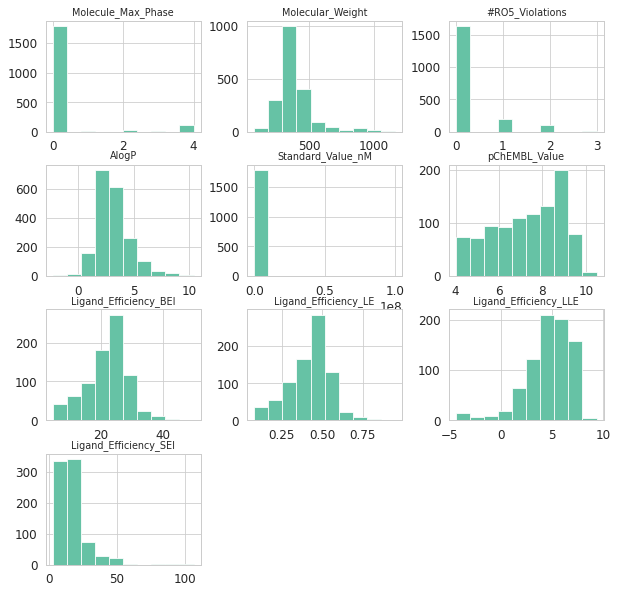

In [35]:
chembl[numeric_cols].hist(figsize=(10,10));

- **Note that pChembl value is better normalized than standard value**
- **Recall that there are lots of different activity types/assays represented in the value columns. Let's split those up:**

Standard_Type      % Ctrl  \
count            7.000000   
mean           109.714286   
std             15.283044   
min             94.000000   
25%             99.000000   
50%            101.000000   
75%            120.500000   
max            134.000000   

Standard_Type  % Inhibition of Control Specific Binding (Mean n=2)  \
count                                                   8.000000     
mean                                                   -3.700000     
std                                                     4.452287     
min                                                   -10.700000     
25%                                                    -6.350000     
50%                                                    -4.350000     
75%                                                     0.350000     
max                                                     2.000000     

Standard_Type      Activity          EC50   Efficacy       Emax  \
count             41.000000     24.000000   4.000000   2.000000   
mean             260.273171   7554.570706  25.225000  54.500000   
std             1559.327343  13061.147535  28.866402  55.861436   
min              -12.900000      1.100000  -0.100000  15.000000   
25%               -0.500000    178.000000   5.225000  34.750000   
50%                2.000000    214.222222  18.500000  54.500000   
75%               30.000000  10000.000000  38.500000  74.250000   
max            10000.000000  50118.720000  64.000000  94.000000   

Standard_Type           IC50  Inhibition            Ka   Kb            Kd  \
count             498.000000  418.000000     23.000000  1.0      4.000000   
mean            10069.385426   28.305755   7869.565217  0.3   3270.980750   
std             27059.164344   26.899361   2937.289224  NaN   6486.129538   
min                 0.090000  -18.890000   2200.000000  0.3      0.416000   
25%                 1.720000    4.062500   5350.000000  0.3      0.484250   
50%                80.350000   25.150000  10000.000000  0.3     41.753500   
75%              5451.162500   50.000000  10000.000000  0.3   3312.250000   
max            257039.580000  100.000000  10000.000000  0.3  13000.000000   

Standard_Type            Ki        Vmax  
count          5.020000e+02   25.000000  
mean           2.076276e+05   94.480000  
std            4.463049e+06   17.535084  
min            0.000000e+00   34.500000  
25%            7.300000e+00   96.000000  
50%            1.654800e+02  100.200000  
75%            4.934302e+03  104.000000  
max            1.000000e+08  107.900000

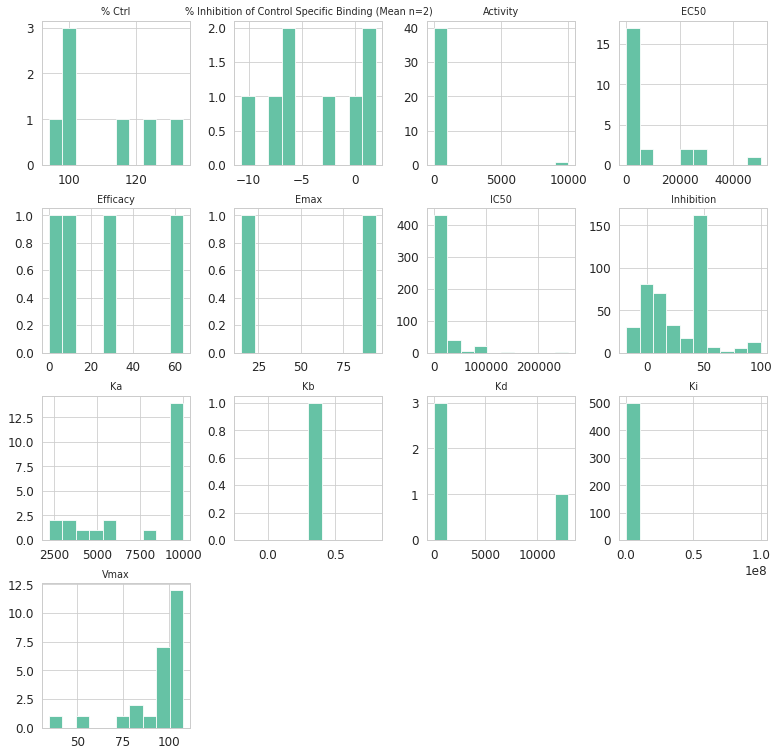

In [36]:
# examine standard values and pChembl values PER standard type
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='Standard_Value_nM', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(13,13));

 What do you notice about the standard values?

In [37]:
chembl.head(3)

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase  Molecular_Weight  \
0      CHEMBL3233676           NaN                 0.0            622.85   
1          CHEMBL773       GLYCINE                 4.0             75.07   
2      CHEMBL3261486           NaN                 0.0            312.37   

   #RO5_Violations  AlogP Compound_Key  \
0              2.0   6.84          22a   
1              0.0  -0.97      glycine   
2              0.0   0.88            9   

                                              Smiles Standard_Type  \
0  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...    Inhibition   
1                                           NCC(=O)O          EC50   
2    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2      Activity   

  Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
0               '='           13.75              %            NaN   
1               NaN             NaN            NaN            NaN   
2               '='           83.00              %            NaN   

  Data_Validity_Comment         Comment    Uo_Units  Ligand_Efficiency_BEI  \
0                   NaN             NaN  UO_0000187                    NaN   
1                   NaN  Not Determined         NaN                    NaN   
2                   NaN             NaN  UO_0000187                    NaN   

   Ligand_Efficiency_LE  Ligand_Efficiency_LLE  Ligand_Efficiency_SEI  \
0                   NaN                    NaN                    NaN   
1                   NaN                    NaN                    NaN   
2                   NaN                    NaN                    NaN   

   Potential_Duplicate Assay_ChEMBL_ID  \
0                False   CHEMBL3240658   
1                False    CHEMBL896288   
2                False   CHEMBL3268498   

                                   Assay_Description Assay_Type BAO_Format_ID  \
0  Reversible inhibition of human 5-HT3A expresse...          B   BAO_0000219   
1  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   
2  Partial agonist activity at human 5-HT3A recep...          B   BAO_0000219   

           BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID Assay_Tissue_Name  \
0  cell-based format   Homo sapiens                    NaN               NaN   
1  cell-based format   Homo sapiens                    NaN               NaN   
2  cell-based format   Homo sapiens                    NaN               NaN   

  Assay_Cell_Type  Assay_Subcellular_Fraction Assay_Parameters  \
0             NaN                         NaN              NaN   
1          HEK293                         NaN              NaN   
2          HEK293                         NaN              NaN   

  Assay_Variant_Accession Assay_Variant_Mutation Target_ChEMBL_ID  \
0                     NaN                    NaN       CHEMBL1899   
1                     NaN                    NaN       CHEMBL1899   
2                     NaN                    NaN       CHEMBL1899   

                      Target_Name Target_Organism     Target_Type  \
0  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   
1  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   
2  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   

  Document_ChEMBL_ID  Source_ID     Source_Description  \
0      CHEMBL3232706          1  Scientific Literature   
1      CHEMBL1148788          1  Scientific Literature   
2      CHEMBL3259590          1  Scientific Literature   

           Document_Journal  Document_Year Cell_ChEMBL_ID Properties  \
0        Eur. J. Med. Chem.         2014.0            NaN        NaN   
1             J. Med. Chem.         2007.0  CHEMBL3307715        NaN   
2  Bioorg. Med. Chem. Lett.         2014.0  CHEMBL3307715        NaN   

   Standard_Value_nM  
0              13.75  
1                NaN  
2              83.00

## EDA plays an important role during harmonization?

In [38]:
dd = chembl[chembl['Molecule_ChEMBL_ID'] == 'CHEMBL1189679']
dd[dd['Standard_Type'] == 'IC50']['pChEMBL_Value'].mean()


8.66875

In [39]:
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='pChEMBL_Value', aggfunc='mean')

In [40]:
chembl_types[chembl_types.index == 'CHEMBL1189679']


Standard_Type       EC50     IC50     Kd    Ki
Molecule_ChEMBL_ID                            
CHEMBL1189679        NaN  8.66875  9.426  10.5

Standard_Type       EC50        IC50        Kd          Ki
count          19.000000  408.000000  4.000000  405.000000
mean            6.684474    7.357423  7.681750    7.178580
std             1.152117    1.676965  2.153942    1.435567
min             4.580000    4.000000  4.890000    4.000000
25%             6.120000    5.792500  6.532500    6.150000
50%             6.750000    7.755000  8.205500    7.285000
75%             7.210000    8.900000  9.354750    8.330000
max             8.960000   10.050000  9.426000   10.500000

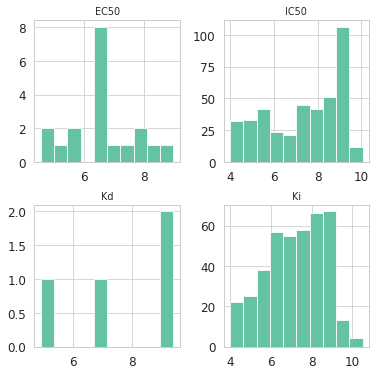

In [41]:
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6));

- **What do you notice about the pChEMBL values?**

# **ExCAPE-DB Dataset Curation**

In [42]:
excape=excape.replace('None', np.nan)
excape.head()

Ambit_InchiKey Original_Entry_ID  Entrez_ID Activity_Flag  \
0  AZGOVLGMSGAOMP-FZYUQVBKNA-N      CHEMBL404232       3359             A   
1  BAZZAIKMNMNZJS-PKRZOPRNNA-N      CHEMBL494999      79246             A   
2  ARXTZNGJWWBBMH-LQFNOIFHNA-N          44157937      79246             A   
3  ASQVLAWCAVGHRV-UHFFFAOYNA-N      CHEMBL576046      79246             A   
4  ATBPRFXCCZLQCU-KHCWMJRFNA-N       CHEMBL40260       3359             A   

     pXC50        DB  Original_Assay_ID  Tax_ID Gene_Symbol  Ortholog_Group  \
0  5.52000  chembl20             989092    9606       HTR3A            2102   
1  7.36000  chembl20             523350   10116       HTR3A            2102   
2  8.52288   pubchem             375321   10116       HTR3A            2102   
3  7.65000  chembl20             592418   10116       HTR3A            2102   
4  8.48000  chembl20               3470    9606       HTR3A            2102   

                                              SMILES  
0        C=1C=C2C(/C=C/3\C(N(C(N3C)=N)C)=O)=CNC2=CC1  
1  N=1C=2C=CC=C(C)C2N3C(=CC=C3)C1N4CCN(CC4)C(C(=O...  
2   OC(=NO)CN1CCN(CC1)C2=NC=3C(N4C2=CC=C4)=C(C=CC3)C  
3  N1(C=NC=C1)CCN2CCN(C3=NC4=CC(=CC=C4N5C3=CC=C5)...  
4             C1(C=2N=C(CN=C(N)N)SC2)=CNC=3C1=CC=CC3

Entrez_ID       pXC50  Original_Assay_ID        Tax_ID  \
count    649.000000  645.000000       6.490000e+02    649.000000   
mean   16215.274268    6.983770       6.633640e+05   9715.318952   
std    27698.741204    1.505524       2.569910e+05    207.728422   
min     3359.000000    1.000000       3.123000e+03   9606.000000   
25%     3359.000000    5.800000       5.369680e+05   9606.000000   
50%     3359.000000    7.161150       6.525690e+05   9606.000000   
75%     3359.000000    8.140000       8.059070e+05   9606.000000   
max    79246.000000   10.500000       1.350972e+06  10116.000000   

       Ortholog_Group  
count           649.0  
mean           2102.0  
std               0.0  
min            2102.0  
25%            2102.0  
50%            2102.0  
75%            2102.0  
max            2102.0

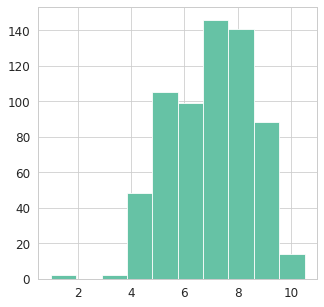

In [43]:
# excape only has one column we care about
display(excape.describe())
excape.pXC50.hist(figsize=(5,5));

## Compare pResponse values across ChEMBL and Excape-DB
- create a histogram or kde plot with legend showing distributions for all three datasets on the same plot

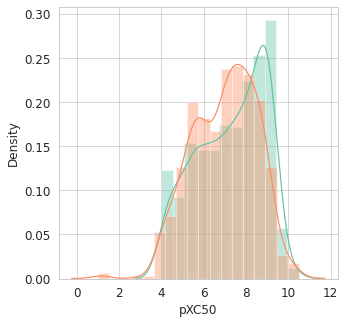

In [44]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(chembl.pChEMBL_Value, ax=ax)
sns.distplot(excape.pXC50, ax=ax);

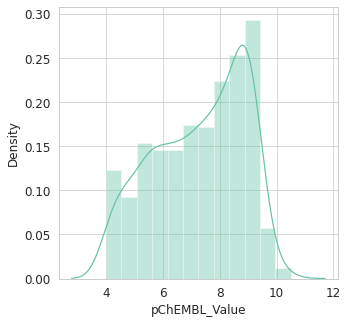

In [45]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(chembl.pChEMBL_Value, ax=ax)

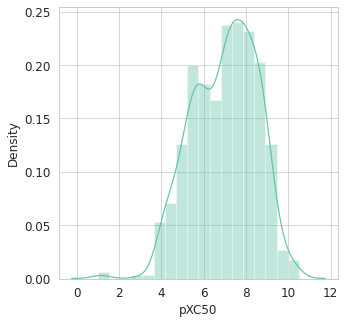

In [46]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(excape.pXC50, ax=ax);

# **Analysis**
- what value types you would model and why?
- how would you use this data for a classification model?
- do any of the three datasets include a column you could use for classification?

<p> I would model either pXC50 or pKI values. They are the most abundant in the dataset and commonly used for modeling. pKI is more normally distributed, but pXC50 values allow inclusion of excape data. 

According to some sources, these two datapoints can be combined in various ways, as well, but that's beyond the scope of this class.

I would choose a reasonable IC50 concentration to use as a threshold (perhaps 10uM, or consult with a scientist), and anything with an IC50 above that threshold is inactive (you need more drug to get activity) and IC50s below this threshold is active (you need less drug for activity, meaning the compound is MORE active per unit)

## EDA tips
- Make sure smiles strings exist since that's what AMPL uses
- Compare compounds in each dataset
- Featurize with ECFP fingerprints
- Examine diversity of compound set

# **EDA: Examine compound overlaps**
Start with questions you have about the compounds at this point in time, such as:
- what compounds are in each set? do they overlap?
- are the compounds diverse or all very similar to each other?

In [47]:
from matplotlib_venn import venn3
from matplotlib_venn import venn2

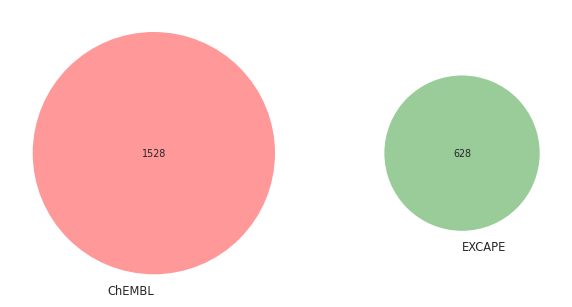

In [48]:
# overlaps from SMILES strings
venn2([set(chembl.Smiles), set(excape.SMILES)], set_labels = ['ChEMBL', 'EXCAPE']);

The chembl IDs overlap, why not the smiles strings? One explanation is that each database's SMILES string representations are slightly different. Answer? **STANDARDIZE the smiles strings.**

# **Curation step:** Standardize smiles strings, drop rows without base smiles

In [49]:
chembl['base_rdkit_smiles'] = chembl.Smiles.apply(curate_data.base_smiles_from_smiles)
print(len(chembl.Smiles))
print(len(chembl.Smiles.unique()))
print(len(chembl.base_rdkit_smiles.unique()))

1950
1528
1528


In [50]:
chembl[chembl.base_rdkit_smiles=='']

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase  Molecular_Weight  \
1638      CHEMBL4532510           NaN                 0.0               NaN   

      #RO5_Violations  AlogP Compound_Key Smiles Standard_Type  \
1638              NaN    NaN          NaN    NaN    Inhibition   

     Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
1638               '='            4.05              %            NaN   

     Data_Validity_Comment     Comment    Uo_Units  Ligand_Efficiency_BEI  \
1638                   NaN  Not Active  UO_0000187                    NaN   

      Ligand_Efficiency_LE  Ligand_Efficiency_LLE  Ligand_Efficiency_SEI  \
1638                   NaN                    NaN                    NaN   

      Potential_Duplicate Assay_ChEMBL_ID  \
1638                False   CHEMBL4507808   

                        Assay_Description Assay_Type BAO_Format_ID  \
1638  GPCRScan assay: inhibition of 5-HT3          B   BAO_0000357   

                  BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID  \
1638  single protein format   Homo sapiens                    NaN   

     Assay_Tissue_Name Assay_Cell_Type  Assay_Subcellular_Fraction  \
1638               NaN             NaN                         NaN   

                                       Assay_Parameters  \
1638  Parental cells: HEKT | PMID: 2164935/8436978 |...   

     Assay_Variant_Accession Assay_Variant_Mutation Target_ChEMBL_ID  \
1638                     NaN                    NaN       CHEMBL1899   

                         Target_Name Target_Organism     Target_Type  \
1638  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   

     Document_ChEMBL_ID  Source_ID                       Source_Description  \
1638      CHEMBL4507304         54  Donated Chemical Probes - SGC Frankfurt   

     Document_Journal  Document_Year Cell_ChEMBL_ID  \
1638              NaN            NaN            NaN   

                               Properties  Standard_Value_nM base_rdkit_smiles  
1638  Compound concentration None 10.0 uM               4.05

In [51]:
chembl=chembl.replace('',np.nan)
chembl[chembl.base_rdkit_smiles.isna()]

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase  Molecular_Weight  \
1638      CHEMBL4532510           NaN                 0.0               NaN   

      #RO5_Violations  AlogP Compound_Key Smiles Standard_Type  \
1638              NaN    NaN          NaN    NaN    Inhibition   

     Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
1638               '='            4.05              %            NaN   

     Data_Validity_Comment     Comment    Uo_Units  Ligand_Efficiency_BEI  \
1638                   NaN  Not Active  UO_0000187                    NaN   

      Ligand_Efficiency_LE  Ligand_Efficiency_LLE  Ligand_Efficiency_SEI  \
1638                   NaN                    NaN                    NaN   

      Potential_Duplicate Assay_ChEMBL_ID  \
1638                False   CHEMBL4507808   

                        Assay_Description Assay_Type BAO_Format_ID  \
1638  GPCRScan assay: inhibition of 5-HT3          B   BAO_0000357   

                  BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID  \
1638  single protein format   Homo sapiens                    NaN   

     Assay_Tissue_Name Assay_Cell_Type  Assay_Subcellular_Fraction  \
1638               NaN             NaN                         NaN   

                                       Assay_Parameters  \
1638  Parental cells: HEKT | PMID: 2164935/8436978 |...   

     Assay_Variant_Accession Assay_Variant_Mutation Target_ChEMBL_ID  \
1638                     NaN                    NaN       CHEMBL1899   

                         Target_Name Target_Organism     Target_Type  \
1638  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   

     Document_ChEMBL_ID  Source_ID                       Source_Description  \
1638      CHEMBL4507304         54  Donated Chemical Probes - SGC Frankfurt   

     Document_Journal  Document_Year Cell_ChEMBL_ID  \
1638              NaN            NaN            NaN   

                               Properties  Standard_Value_nM base_rdkit_smiles  
1638  Compound concentration None 10.0 uM               4.05               NaN

In [52]:
chembl=chembl[~chembl.base_rdkit_smiles.isna()]

In [53]:
chembl[chembl.base_rdkit_smiles=='']

Empty DataFrame
Columns: [Molecule_ChEMBL_ID, Molecule_Name, Molecule_Max_Phase, Molecular_Weight, #RO5_Violations, AlogP, Compound_Key, Smiles, Standard_Type, Standard_Relation, Standard_Value, Standard_Units, pChEMBL_Value, Data_Validity_Comment, Comment, Uo_Units, Ligand_Efficiency_BEI, Ligand_Efficiency_LE, Ligand_Efficiency_LLE, Ligand_Efficiency_SEI, Potential_Duplicate, Assay_ChEMBL_ID, Assay_Description, Assay_Type, BAO_Format_ID, BAO_Label, Assay_Organism, Assay_Tissue_ChEMBL_ID, Assay_Tissue_Name, Assay_Cell_Type, Assay_Subcellular_Fraction, Assay_Parameters, Assay_Variant_Accession, Assay_Variant_Mutation, Target_ChEMBL_ID, Target_Name, Target_Organism, Target_Type, Document_ChEMBL_ID, Source_ID, Source_Description, Document_Journal, Document_Year, Cell_ChEMBL_ID, Properties, Standard_Value_nM, base_rdkit_smiles]
Index: []

## Standardize other datasets
- what do you notice about the number of unique smiles strings before and after standardization?
- what does this mean for the nature of the compounds in a given dataset?
- hint: look at chemical identifiers that have the same base_rdkit_smiles, and the 'DB' column in excape

In [54]:
excape['base_rdkit_smiles'] = excape.SMILES.apply(curate_data.base_smiles_from_smiles)

In [55]:
excape = excape.replace('',np.nan)
excape[excape.base_rdkit_smiles.isna()]

Empty DataFrame
Columns: [Ambit_InchiKey, Original_Entry_ID, Entrez_ID, Activity_Flag, pXC50, DB, Original_Assay_ID, Tax_ID, Gene_Symbol, Ortholog_Group, SMILES, base_rdkit_smiles]
Index: []

In [56]:
excape.iloc[:, [-1, -2]].head(3)

base_rdkit_smiles  \
0            CN1C(=N)N(C)/C(=C/c2c[nH]c3ccccc23)C1=O   
1  Cc1cccc2nc(N3CCN(C(C(=O)O)c4ccccc4)CC3)c3cccn3c12   
2           Cc1cccc2nc(N3CCN(CC(O)=NO)CC3)c3cccn3c12   

                                              SMILES  
0        C=1C=C2C(/C=C/3\C(N(C(N3C)=N)C)=O)=CNC2=CC1  
1  N=1C=2C=CC=C(C)C2N3C(=CC=C3)C1N4CCN(CC4)C(C(=O...  
2   OC(=NO)CN1CCN(CC1)C2=NC=3C(N4C2=CC=C4)=C(C=CC3)C

**Note the name `Smiles` compared to dtc and excape**

In [57]:
chembl[['base_rdkit_smiles','Smiles']].head(3)

base_rdkit_smiles  \
0  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...   
1                                           NCC(=O)O   
2    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2   

                                              Smiles  
0  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...  
1                                           NCC(=O)O  
2    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2

# **Curation step:** Save standardized datasets

If want to save the files for later use, mount your google drive and create a folder and save it there. 

In [58]:
%%bash 
mkdir -p /content/drive/MyDrive/AMPL_EDA_07

In [59]:
chembl.to_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_ChEMBL_SMILES_std.csv")
excape.to_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_Excape_SMILES_std.csv")

## Examine compound overlaps from standardized smiles strings
- create venn diagram with 3 circles for all 3 datasets

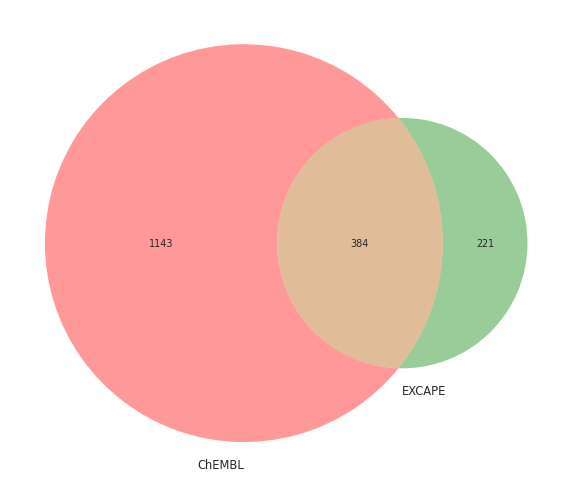

In [60]:
mpv.venn2([set(chembl.base_rdkit_smiles),
           set(excape.base_rdkit_smiles)],
          set_labels = ['ChEMBL', 'EXCAPE']);

That's more like it. For even further overlaps, it's possible to pass all of them through the pubchem ID exchange: use input as smiles and output as smiles, then create base_rdkit_smiles again. You should see some increase in overlap with this pre-processing step.

# **EDA: Examine compound diversity**

 If you want to restart, you can start from here. Please uncomment the following code chunk 

In [61]:
chembl.to_csv("HTR3A_ChEMBL_SMILES_std.csv", index=False)
excape.to_csv("HTR3A_Excape_SMILES_std.csv", index=False)

In [62]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoDistMat

import umap
from scipy.stats.kde import gaussian_kde
from scipy.cluster.hierarchy import linkage

ndist_max = 1000000

def plot_tani_dist_distr(dataset, smiles_col, dataset_name, **metric_kwargs):
    """
    Generate a density plot showing the distribution of distances between ecfp feature
    vectors, using the tanimoto metric.
    """
    # log = logging.getLogger('ATOM')
    num_cmpds = len(dataset)
    if num_cmpds > 50000:
        log.warning("Dataset has %d compounds, too big to calculate distance matrix" % num_cmpds)
        return

    # log.warning("Starting distance matrix calculation for %d compounds" % num_cmpds)
    feat_type = 'ecfp'
    dist_metric = 'tanimoto'
    smiles_arr1 = dataset[smiles_col].values
    mols1 = [Chem.MolFromSmiles(s) for s in smiles_arr1]
    fprints1 = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in mols1]
    dists = GetTanimotoDistMat(fprints1)

    # log.warning("Finished calculation of %d distances" % len(dists))

    if len(dists) > ndist_max:
        # Sample a subset of the distances so KDE doesn't take so long
        dist_sample = np.random.choice(dists, size=ndist_max)
    else:
        dist_sample = dists

    dist_pdf = gaussian_kde(dist_sample)
    x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
    y_plt = dist_pdf(x_plt)
    fig, ax = plt.subplots(figsize=(8.0,8.0))
    ax.plot(x_plt, y_plt)
    ax.set_xlabel('%s distance' % dist_metric)
    ax.set_ylabel('Density')
    ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
                  dataset_name, dist_metric, feat_type))
    return dists


array([0.93548387, 0.86206897, 0.98076923, ..., 0.88235294, 0.84810127,
       0.9047619 ])

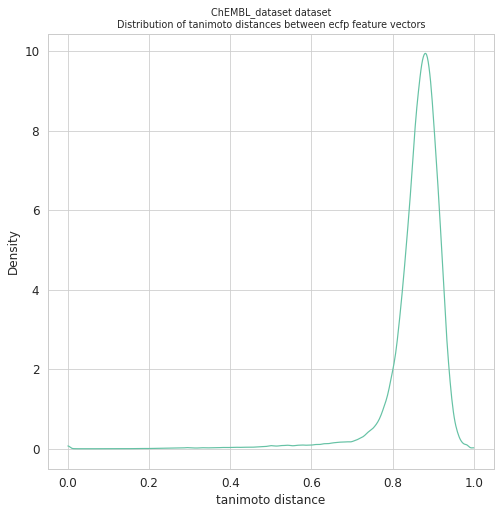

In [63]:
plot_tani_dist_distr(chembl, 'base_rdkit_smiles', 'ChEMBL_dataset')

In [64]:
chembl[['Molecule_ChEMBL_ID','base_rdkit_smiles','pChEMBL_Value']].head(3)

Molecule_ChEMBL_ID                                  base_rdkit_smiles  \
0      CHEMBL3233676  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...   
1          CHEMBL773                                           NCC(=O)O   
2      CHEMBL3261486    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2   

   pChEMBL_Value  
0            NaN  
1            NaN  
2            NaN

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


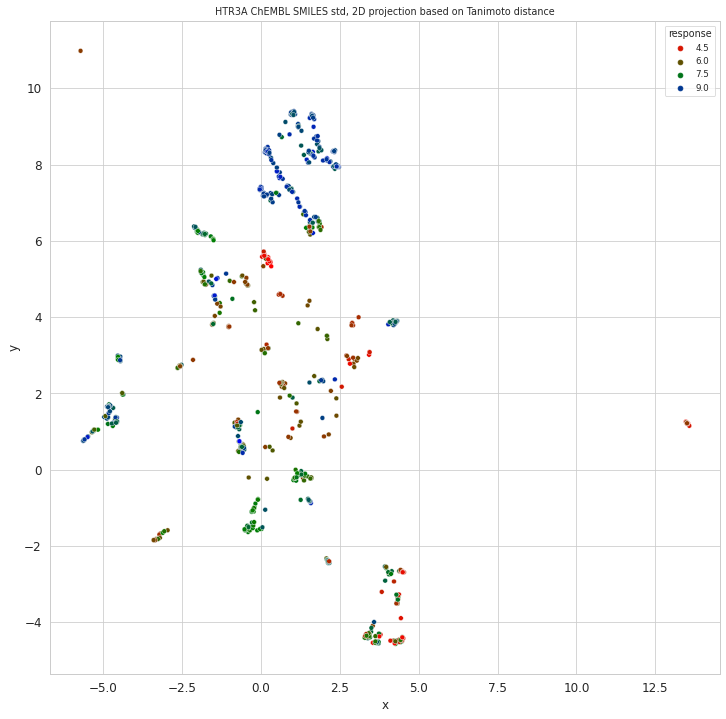

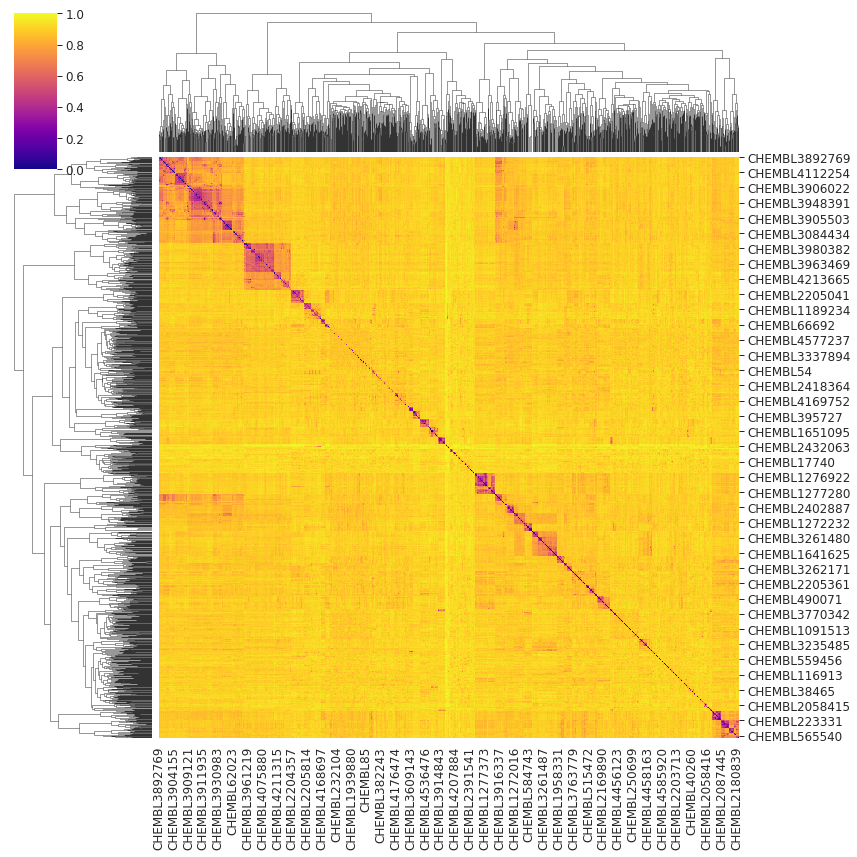

In [65]:
dp.diversity_plots(dset_key='/content/drive/MyDrive/AMPL_EDA_07/HTR3A_ChEMBL_SMILES_std.csv',
                   datastore=False, 
                   id_col ='Molecule_ChEMBL_ID', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pChEMBL_Value')

## Create plots for Excape
- What happens when you change the ecfp radius?
- bonus: try creating MCS plots by looking at the documentation of the diversity_plots function
- warning: it is very slow for >1000 ish compounds. 
- extra bonus: select a random subset of 1000 compounds and create the MCS plots.

array([0.86842105, 0.90789474, 0.40983607, ..., 0.22058824, 0.77777778,
       0.77777778])

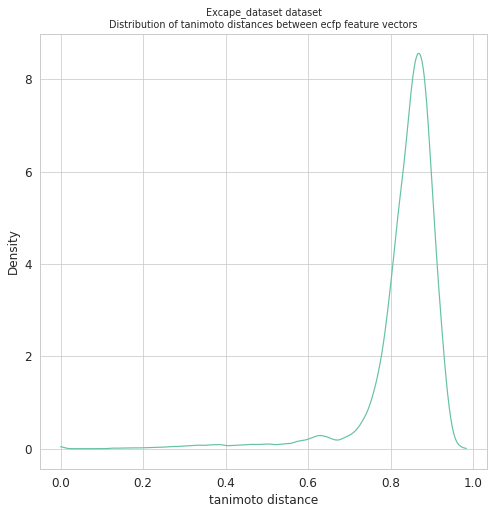

In [66]:
plot_tani_dist_distr(excape, 'base_rdkit_smiles', 'Excape_dataset')

In [67]:
excape.columns


Index(['Ambit_InchiKey', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'SMILES', 'base_rdkit_smiles'],
      dtype='object')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


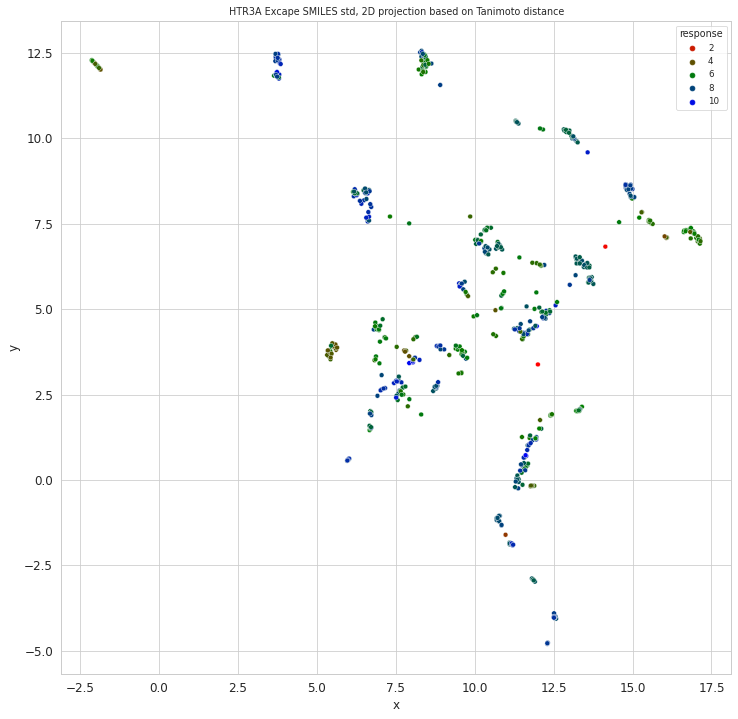

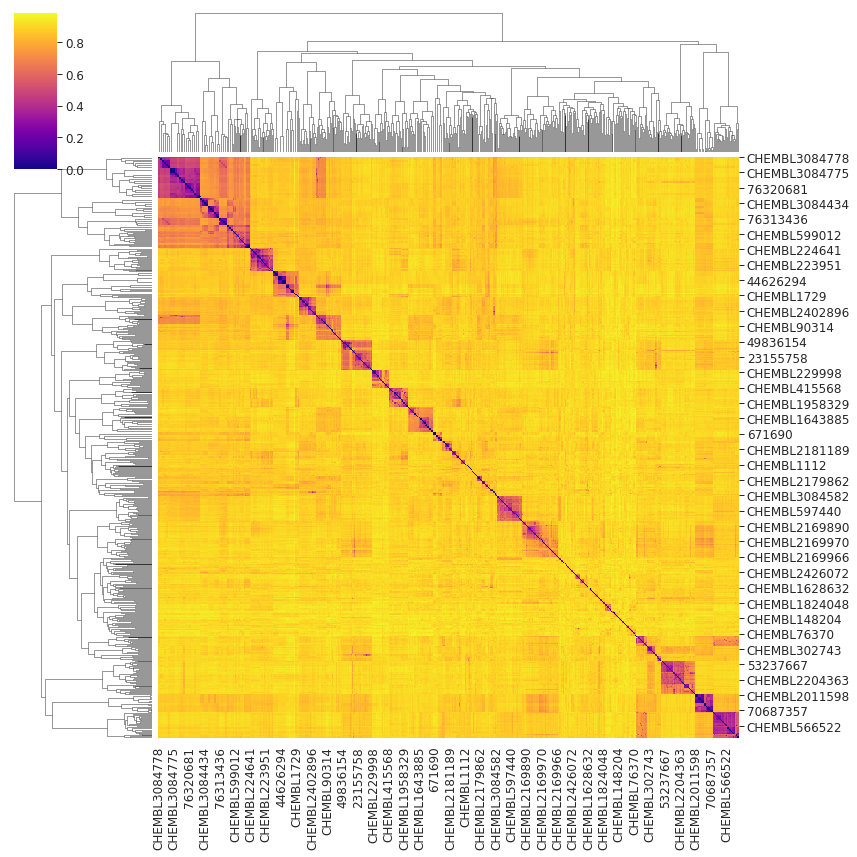

In [68]:
dp.diversity_plots('/content/drive/MyDrive/AMPL_EDA_07/HTR3A_Excape_SMILES_std.csv',
                   datastore=False, 
                   id_col ='Original_Entry_ID', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50')

## Discussion on the analysis of the heatmap and density plots
```
what are Morgan fingerprints (ecfp)? 
what does radius mean?
what does a bit in an ECFP vector correspond to?
what radius and vector length are used in these functions?
hint: look at the .py files for more info
```
ECFP fingerprints are a bit vector representation of a compound's structure. Each bit represents the presence or absence of a certain 'connectivity' between atoms in a molecule. The radius used in the diversity plots function is radius 4 and length 1024. The tanimoto plot function uses radius 2. Radius means number of atoms you travel away from the given atom to assess connectivity, allowing you to look at larger or smaller molecule fragments.


```
what is tanimoto distance? What do values closer to zero or closer to one mean?
Do you think your sets of compounds are diverse?
What do you observe from the 2D projection of compounds?
Are there any similarities between groups of compounds in your datasets?
```

Tanimoto similarity (or jaccard index) represents how well two bit vectors overlap. Thus, distance represents how 'far' away they are from perfect overlap. A distance closer 1 means the fingerprints (and therefore molecules) are less similar to each other. A distance closer to zero means molecules are more similar. 

Compounds that are shown in this exercise have average tanimoto distances ~ 0.85 - 0.9, so they are fairly diverse.

In the ChEMBL dataset, the 2D project separates high and low pChEMBL values very well.  

From the heatmap, we can see clusters/squares of compounds with tanimoto distance closer to zero (purple) so I suspect there are some groups of compounds that are very similar.


# **EDA: Curated data**
- First let us curate the data
- Examine new compound overlaps
- Examine final response column distributions
- Filter for 
  - large compounds
  - too high / too low pXC50 values
- double check for no NA values left
- save final curated dataset for further processing

Start here if you want to restart from here. Dont forget to uncomment the following code chunk

In [69]:
# chembl=pd.read_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_ChEMBL_SMILES_std.csv", index_col=0)
# excape=pd.read_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_Excape_SMILES_std.csv", index_col=0)

In [70]:
# rescue NA pChemblValues
chembl['pChEMBL_Value_nM'] = -np.log10(chembl.Standard_Value_nM/1000000000)

In [71]:
chembl.head(3)

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase  Molecular_Weight  \
0      CHEMBL3233676           NaN                 0.0            622.85   
1          CHEMBL773       GLYCINE                 4.0             75.07   
2      CHEMBL3261486           NaN                 0.0            312.37   

   #RO5_Violations  AlogP Compound_Key  \
0              2.0   6.84          22a   
1              0.0  -0.97      glycine   
2              0.0   0.88            9   

                                              Smiles Standard_Type  \
0  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...    Inhibition   
1                                           NCC(=O)O          EC50   
2    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2      Activity   

  Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
0               '='           13.75              %            NaN   
1               NaN             NaN            NaN            NaN   
2               '='           83.00              %            NaN   

  Data_Validity_Comment         Comment    Uo_Units  Ligand_Efficiency_BEI  \
0                   NaN             NaN  UO_0000187                    NaN   
1                   NaN  Not Determined         NaN                    NaN   
2                   NaN             NaN  UO_0000187                    NaN   

   Ligand_Efficiency_LE  Ligand_Efficiency_LLE  Ligand_Efficiency_SEI  \
0                   NaN                    NaN                    NaN   
1                   NaN                    NaN                    NaN   
2                   NaN                    NaN                    NaN   

   Potential_Duplicate Assay_ChEMBL_ID  \
0                False   CHEMBL3240658   
1                False    CHEMBL896288   
2                False   CHEMBL3268498   

                                   Assay_Description Assay_Type BAO_Format_ID  \
0  Reversible inhibition of human 5-HT3A expresse...          B   BAO_0000219   
1  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   
2  Partial agonist activity at human 5-HT3A recep...          B   BAO_0000219   

           BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID Assay_Tissue_Name  \
0  cell-based format   Homo sapiens                    NaN               NaN   
1  cell-based format   Homo sapiens                    NaN               NaN   
2  cell-based format   Homo sapiens                    NaN               NaN   

  Assay_Cell_Type  Assay_Subcellular_Fraction Assay_Parameters  \
0             NaN                         NaN              NaN   
1          HEK293                         NaN              NaN   
2          HEK293                         NaN              NaN   

  Assay_Variant_Accession Assay_Variant_Mutation Target_ChEMBL_ID  \
0                     NaN                    NaN       CHEMBL1899   
1                     NaN                    NaN       CHEMBL1899   
2                     NaN                    NaN       CHEMBL1899   

                      Target_Name Target_Organism     Target_Type  \
0  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   
1  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   
2  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   

  Document_ChEMBL_ID  Source_ID     Source_Description  \
0      CHEMBL3232706          1  Scientific Literature   
1      CHEMBL1148788          1  Scientific Literature   
2      CHEMBL3259590          1  Scientific Literature   

           Document_Journal  Document_Year Cell_ChEMBL_ID Properties  \
0        Eur. J. Med. Chem.         2014.0            NaN        NaN   
1             J. Med. Chem.         2007.0  CHEMBL3307715        NaN   
2  Bioorg. Med. Chem. Lett.         2014.0  CHEMBL3307715        NaN   

   Standard_Value_nM                                  base_rdkit_smiles  \
0              13.75  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...   
1                NaN                                      

In [72]:
chembl.Standard_Type.unique()

array(['Inhibition', 'EC50', 'Activity', 'IC50', 'Ki', 'Vmax',
       '% Inhibition of Control Specific Binding (Mean n=2)', 'Ka',
       'pIC50', 'Emax', 'Kd', 'pKi', 'Kb', 'Selectivity ratio',
       'Efficacy', '% Ctrl'], dtype=object)

In [73]:
# select pIC50 values
vals = ['EC50', 'IC50', 'pIC50']
print(chembl.shape)
chembl=chembl[chembl.Standard_Type.isin(vals)]
print(chembl.shape)

(1949, 48)
(602, 48)


In [74]:
# drop NA pIC50's & smiles
chembl=chembl.dropna(axis=0, subset = ['pChEMBL_Value_nM','base_rdkit_smiles'])
print(chembl.shape)

(594, 48)


In [75]:
# note weird punctuation
chembl.Standard_Relation.unique()

array(["'='", "'>'", "'<'"], dtype=object)

In [76]:
# flip arrows and fix punctuation for relation column to reflect pValues not normal values
chembl['pRelation'] = chembl.Standard_Relation
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'<'", ">", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'>'", "<", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'='", "=", chembl.pRelation)
chembl[['Standard_Relation', 'pRelation']].head()

Standard_Relation pRelation
3               '='         =
4               '>'         <
5               '='         =
6               '>'         <
7               '>'         <

In [77]:
thresh=-np.log10(100/1000000000) # pIC50 of 100nM for threshold

In [78]:
print(chembl.shape)
chembl_cur = curate_data.aggregate_assay_data(chembl, value_col = 'pChEMBL_Value_nM', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Molecule_ChEMBL_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
print(chembl_cur.shape)
chembl_cur.head()

(594, 49)
0 entries in input table are missing SMILES strings
517 unique SMILES strings are reduced to 517 unique base SMILES strings
(517, 5)


compound_id                                  base_rdkit_smiles relation  \
0  CHEMBL3948391      CN1C2COCC1CC(NC(=O)c1cn(-c3cncs3)c3ncccc13)C2            
1  CHEMBL1277374     Nn1c(CN2CCN(c3ccc4ccccc4n3)CC2)nc2c(c1=O)CCCC2            
2  CHEMBL3311308              COc1ccc(S(=O)(=O)Nc2c(C)cc(C)cc2C)cc1        <   
3   CHEMBL585567  COc1cc(N)c(Cl)cc1C(=O)N[C@H]1CCN(C[C@@H]2CCCC[...            
4  CHEMBL3895877  N#Cc1ccc(-n2cc(C(=O)OC3CC4COCC(C3)N4)c3ccccc32...            

      pXC50  active  
0  9.397940       1  
1  7.062482       1  
2  4.300000       0  
3  7.744727       1  
4  8.228119       1

In [79]:
# chembl_cur.to_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_ChEMBL_cur.csv")

In [80]:
# excape: has no relation col, so create one with all ''
excape['pRelation']=''
print(excape.shape)
print(excape.pRelation.unique())
excape=excape.dropna(axis=0, subset = ['pXC50','base_rdkit_smiles'])
print(excape.shape)
# aggregate duplicates
excape_cur = curate_data.aggregate_assay_data(excape, value_col = 'pXC50', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Original_Entry_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
excape_cur.to_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_Excape_cur.csv")
print(excape_cur.shape)
print(excape_cur.relation.unique())
excape_cur.head()

(649, 13)
['']
(645, 13)
0 entries in input table are missing SMILES strings
601 unique SMILES strings are reduced to 600 unique base SMILES strings
(600, 5)
['']


compound_id                                  base_rdkit_smiles relation  \
0  CHEMBL2011589  Cc1c(N2CCN(C)CC2)nc2ccccc2c1C(=O)NCCCCCCNc1c2c...            
1   CHEMBL415568  C[N+]12CC[C@H]3[C@@H]1C[C@H](C1=CN4c5ccccc5[C@...            
2       44626294  COc1cc(N)c(Cl)cc1C(=O)N[C@H]1CCN(C[C@@H]2CCCC[...            
3  CHEMBL3084765  CCC[C@H]1COCCN1c1nc2c(C(=O)N[C@H]3C[C@@H]4CCC[...            
4  CHEMBL2011587  Cc1c(N2CCN(C)CC2)nc2ccccc2c1C(=O)NCCOCCOCCOCCO...            

     pXC50  active  
0  7.15000       1  
1  5.40000       0  
2  7.74473       1  
3  8.41000       1  
4  7.57000       1

In [81]:
chembl_cur['datasource'] = 'chembl'
excape_cur['datasource']='excape'
HTR3A = pd.concat([chembl_cur, excape_cur])
# HTR3A.to_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_merge.csv")
print(HTR3A.shape)

(1117, 6)


In [82]:
import importlib
importlib.reload(curate_data)
HTR3A_cur = curate_data.aggregate_assay_data(HTR3A, value_col = 'pXC50', 
                                              id_col = 'compound_id', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'relation',
                                              active_thresh=thresh)

print(HTR3A_cur.shape)
print(HTR3A.relation.unique())
HTR3A_cur.head()

0 entries in input table are missing SMILES strings
1004 unique SMILES strings are reduced to 1004 unique base SMILES strings
(1004, 5)
['' '<' '>']


compound_id                                  base_rdkit_smiles relation  \
0  CHEMBL3948391      CN1C2COCC1CC(NC(=O)c1cn(-c3cncs3)c3ncccc13)C2            
1  CHEMBL2011589  Cc1c(N2CCN(C)CC2)nc2ccccc2c1C(=O)NCCCCCCNc1c2c...            
2  CHEMBL1277374     Nn1c(CN2CCN(c3ccc4ccccc4n3)CC2)nc2c(c1=O)CCCC2            
3  CHEMBL3311308              COc1ccc(S(=O)(=O)Nc2c(C)cc(C)cc2C)cc1        <   
4   CHEMBL415568  C[N+]12CC[C@H]3[C@@H]1C[C@H](C1=CN4c5ccccc5[C@...            

      pXC50  active  
0  9.397940       1  
1  7.150000       1  
2  7.062482       1  
3  4.300000       0  
4  5.400000       0

In [83]:
HTR3A_cur.relation.unique()

array(['', '<'], dtype=object)

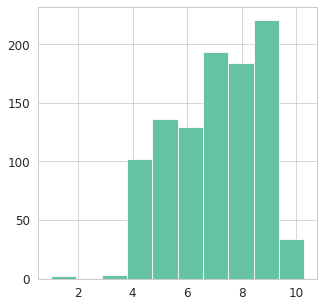

In [84]:
HTR3A_cur.pXC50.hist(figsize=(5,5));

In [85]:
HTR3A_cur.active.sum()

555

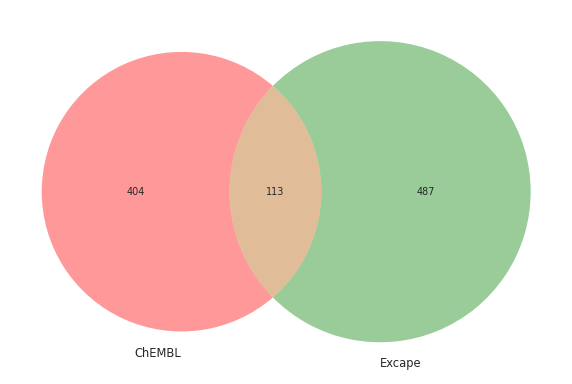

In [86]:
mpv.venn2([set(HTR3A.loc[HTR3A.datasource=='chembl','base_rdkit_smiles']),
           set(HTR3A.loc[HTR3A.datasource=='excape','base_rdkit_smiles']),],
          set_labels = ['ChEMBL','Excape']);

2021-05-31 13:56:29,843 *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


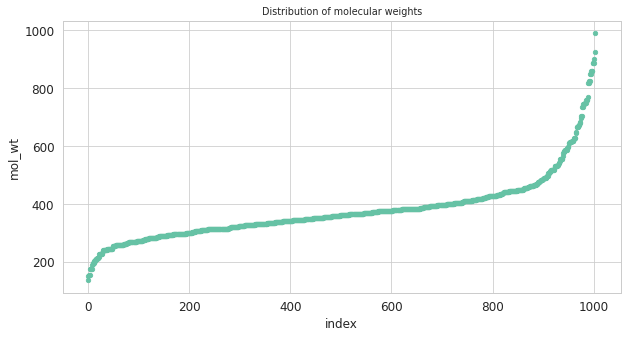

In [87]:
HTR3A_cur["mol_wt"] = [Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smile)) for smile in HTR3A_cur["base_rdkit_smiles"]]
HTR3A_cur = HTR3A_cur.sort_values('mol_wt')
HTR3A_cur=HTR3A_cur.reset_index(drop=True)
HTR3A_cur=HTR3A_cur.reset_index() # plot x axis as index #'s
fig,ax=plt.subplots(figsize=(10,5))
HTR3A_cur.plot(kind='scatter', x='index', y='mol_wt', ax=ax);
plt.title("Distribution of molecular weights");

In [88]:
print(HTR3A_cur.shape)
HTR3A_cur = HTR3A_cur[HTR3A_cur.mol_wt <1400]
print(HTR3A_cur.shape)

(1004, 7)
(1004, 7)


2021-05-31 13:56:30,144 *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


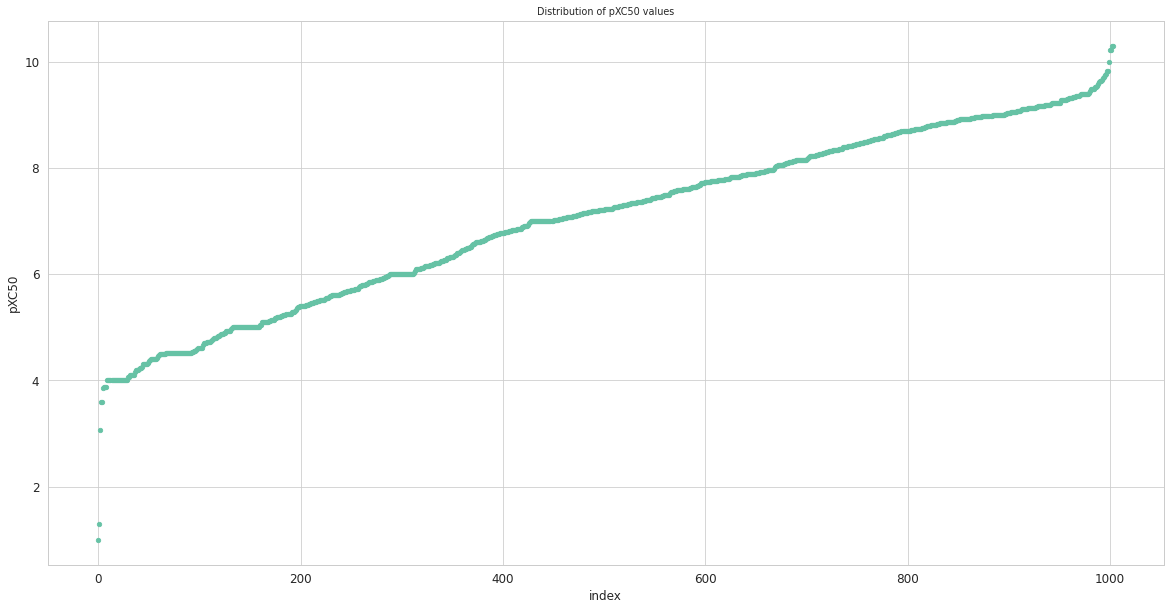

In [89]:
HTR3A_cur=HTR3A_cur.drop(columns=['index'])
HTR3A_cur = HTR3A_cur.sort_values('pXC50')
HTR3A_cur = HTR3A_cur.reset_index(drop=True)
HTR3A_cur = HTR3A_cur.reset_index() # plot x axis as index #'s
fig,ax=plt.subplots(figsize=(20,10))
HTR3A_cur.plot(kind='scatter', x='index', y='pXC50', ax=ax);
plt.title("Distribution of pXC50 values");

In [90]:
print(HTR3A_cur.shape)
HTR3A_cur=HTR3A_cur[HTR3A_cur.pXC50>2]
HTR3A_cur=HTR3A_cur[HTR3A_cur.pXC50<14]
print(HTR3A_cur.shape)

(1004, 7)
(1002, 7)


In [91]:
for col in HTR3A_cur.columns:
  print(col, HTR3A_cur[col].isna().values.any())

index False
compound_id False
base_rdkit_smiles False
relation False
pXC50 False
active False
mol_wt False


array([0.94444444, 0.88888889, 0.94642857, ..., 0.83950617, 0.83950617,
       0.85294118])

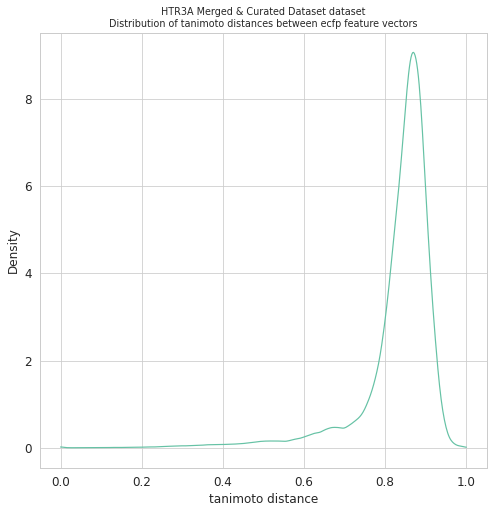

In [92]:
plot_tani_dist_distr(HTR3A_cur, 'base_rdkit_smiles', 'HTR3A Merged & Curated Dataset')

In [93]:
HTR3A_cur.to_csv("/content/HTR3A_cur.csv")

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


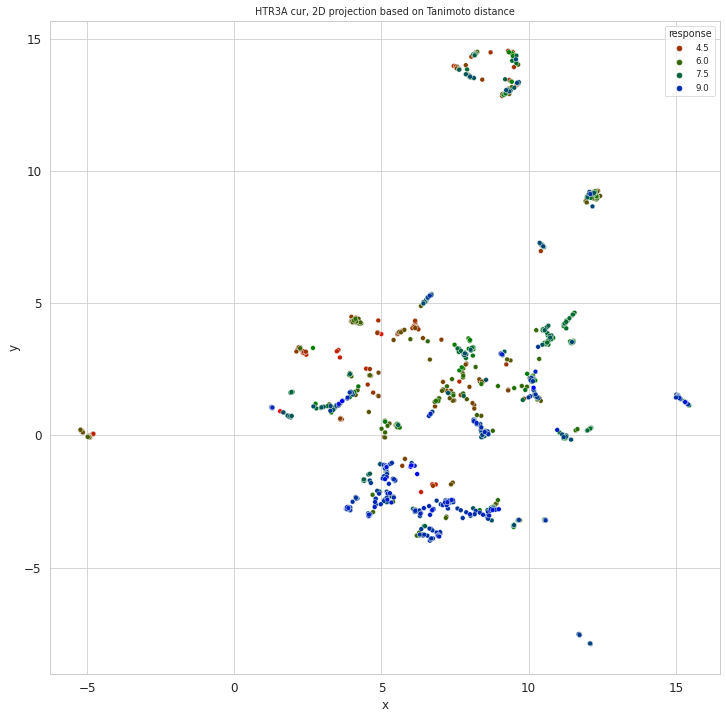

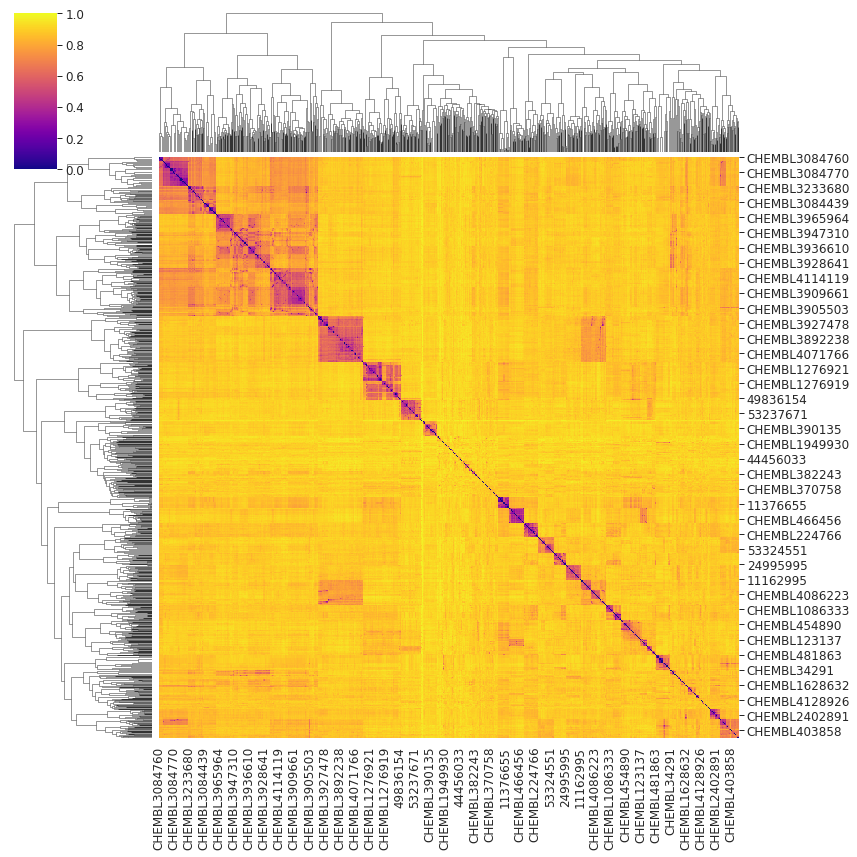

In [94]:
dp.diversity_plots('/content/HTR3A_cur.csv', 
                   datastore = False,
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


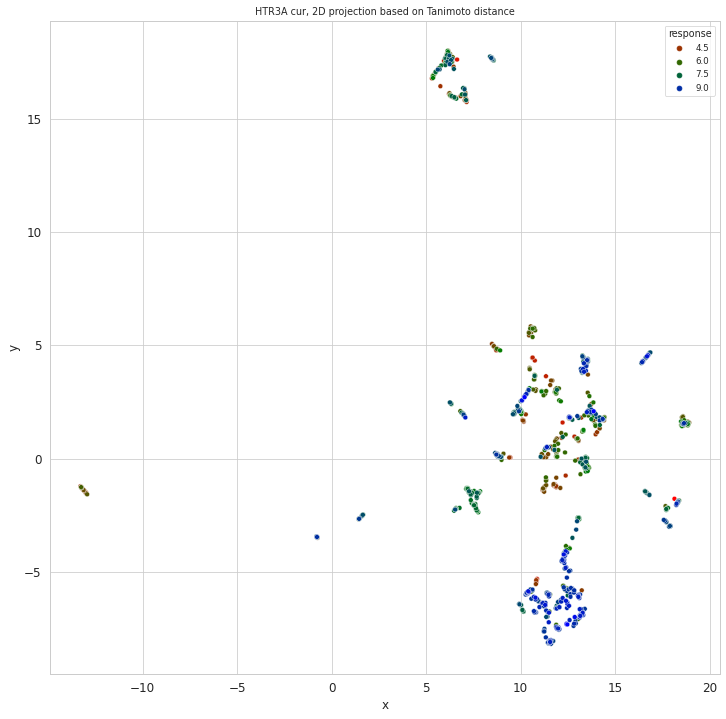

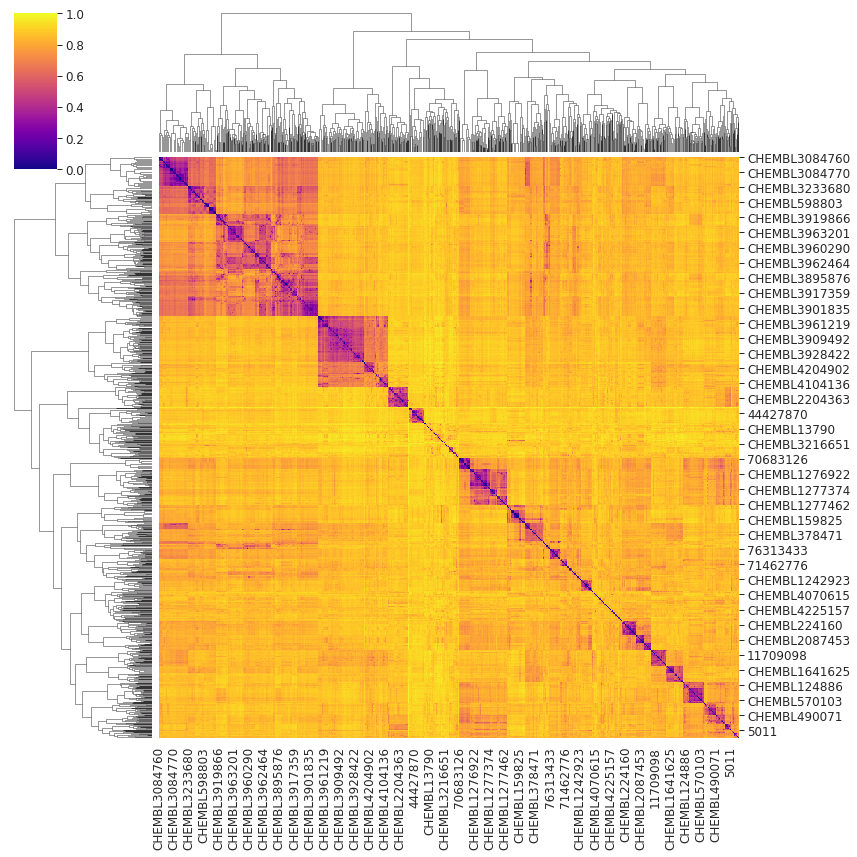

In [95]:
dp.diversity_plots('/content/HTR3A_cur.csv', 
                   datastore = False,
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50',
                   ecfp_radius = 2)

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


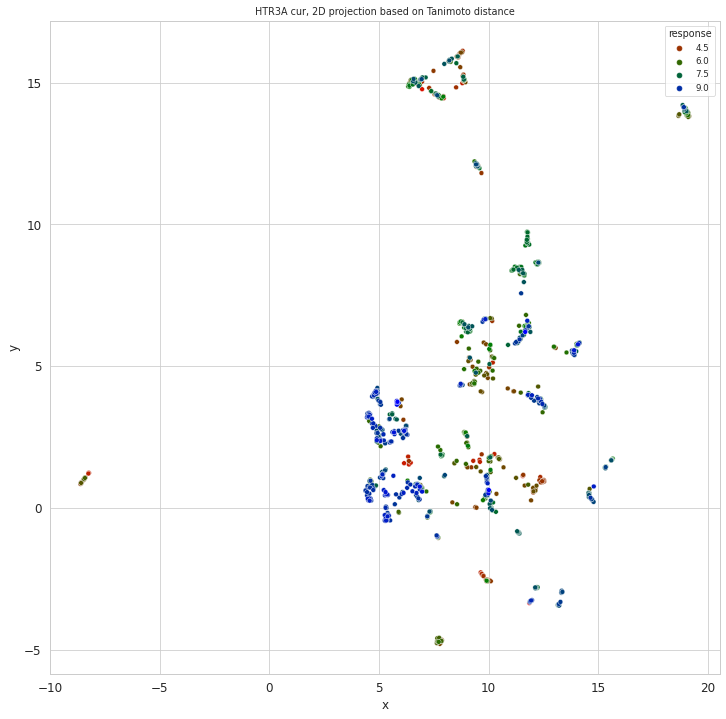

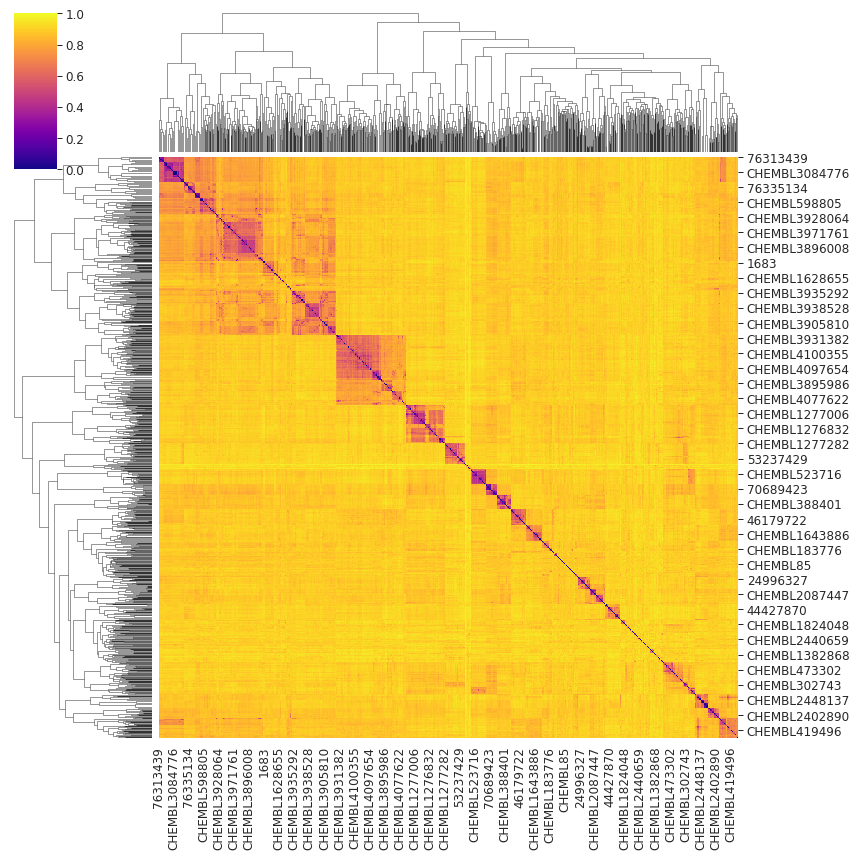

In [96]:
dp.diversity_plots('/content/HTR3A_cur.csv', 
                   datastore = False,
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50',
                   ecfp_radius = 6)

The following code takes too long. Try only when you are running this
on a dedicated server

In [97]:
# warning: 1000 doesn't work, takes too long
importlib.reload(dp)
# dp.diversity_plots('/content/HTR3A_cur.csv', 
#                    id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
#                    is_base_smiles=True, response_col = 'pXC50', 
#                    max_for_mcs=1100)

<module 'atomsci.ddm.pipeline.diversity_plots' from '/usr/local/lib/python3.7/dist-packages/atomsci/ddm/pipeline/diversity_plots.py'>

# **Ready For Next Steps:**


- Featurize with structure-based fingerprints like ECFP
- Molecular descriptor sets like RDKit and Mordred
  - these are high - dimensional datasets (200-2000 features or 'dimensions')
  - so UMAP, tSNE and other dimensionality reduction techniques will help and visualize the 'chemical space' of the dataset

# **Helpful links:** 


1.   https://github.com/ATOMconsortium/AMPL/tree/Tutorials/atomsci/ddm/examples/tutorials
2.   https://github.com/ravichas/ML-predict-drugclass


In [98]:
!date

Mon May 31 13:57:00 UTC 2021
